<a href="https://colab.research.google.com/github/JunjieYU-UoM/AutoML_climate_tutorial/blob/main/tutorial_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

prepare the Python environment

In [1]:
!pip install obswx flaml matplotlib

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.2/297.2 kB 3.4 MB/s eta 0:00:00
  Created wheel for obswx: filename=obswx-0.0.1-py3-none-any.whl size=7093 sha256=bd6735acdc046fd405f6268c411dedda4e1ed4ca9661d4a065e59b7d92063ca0
  Stored in directory: /root/.cache/pip/wheels/8a/16/24/0afa92dfad516f43aa3723afdabe30a4b945ef700135f2e05e
Successfully built obswx


# Tutorial of AutoML for weather data
---

Junjie Yu, PhD candidate

The University of Mancherster, Manchester, UK

Language: Python

Packages: obswx, matplotlib, flaml, numpy, pandas, sklearn

- learn to process time series data
- learn to use the flaml library

Q: What is the time serials data?

A: Time series data is a sequence of data points collected at constant time intervals.
It is used in various fields, such as finance, weather forecasting, and signal processing.
Time series data can be analyzed to identify patterns, trends, and anomalies.

## 0 import the libraries
---

In [2]:
import warnings
warnings.filterwarnings('ignore')

from obswx import *
import numpy as np
from flaml import AutoML
import matplotlib.pyplot as plt
import numpy as np

## 1 download the data of the interested weather station
---
here we use `obswx` package to load the data.

Package homepage: https://envdes.github.io/obswx/index.html

### 1.1 download data from `obswx`

load the metadata.

Q: what is metadata?

A: The data about data.

In [3]:
met = obswx(source='ISD')
# Load the metadata
met.get_meta(load=True).head() #use .head() to print 5 samples in the head of the data
# please check https://www.ncei.noaa.gov/products/land-based-station/integrated-surface-database
# to get more information about the table.

,USAF,WBAN,STATION NAME,CTRY,STATE,ICAO,LAT,LON,ELEV(M),BEGIN,END
0,007018,99999,WXPOD 7018,NaN,NaN,NaN,0.00,0.000,7018.0,20110309,20130730
1,007026,99999,WXPOD 7026,AF,NaN,NaN,0.00,0.000,7026.0,20120713,20170822
2,007070,99999,WXPOD 7070,AF,NaN,NaN,0.00,0.000,7070.0,20140923,20150926
3,008260,99999,WXPOD8270,NaN,NaN,NaN,0.00,0.000,0.0,20050101,20120731
4,008268,99999,WXPOD8278,AF,NaN,NaN,32.95,65.567,1156.7,20100519,20120323


here we can select the weater **station** by combining USAF and WBAN

03334099999: Manchester airport.

Here to help select station: https://envdes.github.io/obswx/isd_map

In [4]:
df = met.get_data(year=2023, station= "03334099999", isd_source="AWS")
df['TMP'] = df['TMP'].replace(',','.', regex=True).astype(float) # transform the temperature to float
df.index = pd.to_datetime(df['DATE']) # set the date as index

Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map


In [5]:
df.head()

,STATION,DATE,SOURCE,LATITUDE,LONGITUDE,ELEVATION,NAME,REPORT_TYPE,CALL_SIGN,QUALITY_CONTROL,...,GA2,GA3,GA4,GE1,GF1,MA1,MW1,MW2,OC1,REM
DATE,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:20:00,3334099999,2023-01-01T00:20:00,4,53.353744,-2.27495,78.33,"MANCHESTER, UK",FM-15,99999,V020,...,NaN,NaN,NaN,"9,AGL ,+99999,+99999","99,99,9,04,1,99,9,01341,1,99,9,99,9","09960,1,99999,9",NaN,NaN,NaN,MET081METAR EGCC 010020Z AUTO 19006KT 150V230 ...
2023-01-01 00:50:00,3334099999,2023-01-01T00:50:00,4,53.353744,-2.27495,78.33,"MANCHESTER, UK",FM-15,99999,V020,...,NaN,NaN,NaN,NaN,NaN,"09970,1,99999,9",NaN,NaN,NaN,MET068METAR COR EGCC 010050Z AUTO 21012KT 9999...
2023-01-01 01:20:00,3334099999,2023-01-01T01:20:00,4,53.353744,-2.27495,78.33,"MANCHESTER, UK",FM-15,99999,V020,...,"07,1,+01128,1,99,9",NaN,NaN,"9,AGL ,+99999,+99999","99,99,9,07,1,99,9,00914,1,99,9,99,9","09970,1,99999,9",NaN,NaN,NaN,MET079METAR EGCC 010120Z AUTO 21012KT 9999 BKN...
2023-01-01 01:50:00,3334099999,2023-01-01T01:50:00,4,53.353744,-2.27495,78.33,"MANCHESTER, UK",FM-15,99999,V020,...,"04,1,+01372,1,99,9",NaN,NaN,"9,AGL ,+99999,+99999","99,99,9,02,1,99,9,00823,1,99,9,99,9","09970,1,99999,9",NaN,NaN,NaN,MET089METAR COR EGCC 010150Z AUTO 22009KT 9999...
2023-01-01 02:20:00,3334099999,2023-01-01T02:20:00,4,53.353744,-2.27495,78.33,"MANCHESTER, UK",FM-15,99999,V020,...,"07,1,+01036,1,99,9","07,1,+01219,1,99,9",NaN,"9,AGL ,+99999,+99999","99,99,9,04,1,99,9,00884,1,99,9,99,9","09980,1,99999,9",NaN,NaN,NaN,MET080METAR COR EGCC 010220Z AUTO 22007KT 9999...


Q: What format is time data saved in?

A: The time data is saved in the format of datetime64[ns].

Q: How can I access the time data?

A: You can access the time data by using the index of the dataframe.

Q: Are there any types of time data that can be used?

A: timestamp, datetime (Python object), and datetime64[ns] (numpy object). Please refer to the following link for more information: https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html

### 1.2 check the temperature of the raw data

TMP - Mean temperature (.1 Fahrenheit)

here we will not change the unit of temperature (Fahrenheit).

Q: How to present temperature? Which type of temperature is the standard?

A: Celsius (°C), Fahrenheit (°F), Kelvin (K). Kelvin is the standard unit in the International System of Units. Kelvin is an absolute temperature scale where 0 K is absolute zero, equivalent to -273.15°C. Celsius is commonly used in daily life, where Water freezes at 0°C and boils at 100°C (under standard atmospheric pressure). Fahrenheit is popular in the United States

Fahrenheit = Celsius * 5/9 + 32

Kelvin = Celsius + 273.15

<Axes: xlabel='DATE'>

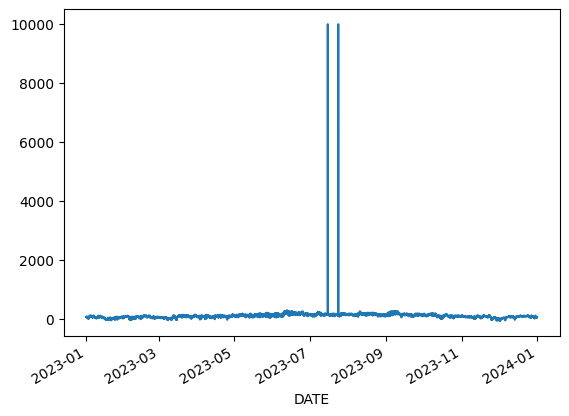

In [6]:
df['TMP'].plot() # check the data

we can see here are some **missing data** that are replaced by 9999.99

### 1.3 How to deal with the missing data?

1. interpolate
    - ref: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
2. drop it
3. fill it with a constant value
    - mean
    - median
    - last observation
    - next observation
4. others (e.g. using a model to predict the missing value)

In [7]:
# 1 find the missing value index
missing_value_index = df.query('TMP >= 9999').index
missing_value_index

DatetimeIndex(['2023-07-15 14:50:00', '2023-07-24 01:50:00'], dtype='datetime64[ns]', name='DATE', freq=None)

In [8]:
# 2 check the missing values
df.loc[missing_value_index]['TMP']

,TMP
DATE,
2023-07-15 14:50:00,9999.9
2023-07-24 01:50:00,9999.9


In [9]:
# 3 fill the missing values using interpolation of linear method
df['T_filled'] = df['TMP'].apply(lambda x: x if x < 9999 else np.nan).interpolate(method='linear')

In [10]:
# 4 print the values
print(df['T_filled'].loc[missing_value_index])

DATE
2023-07-15 14:50:00    175.1
2023-07-24 01:50:00    110.1
Name: T_filled, dtype: float64


<Axes: xlabel='DATE'>

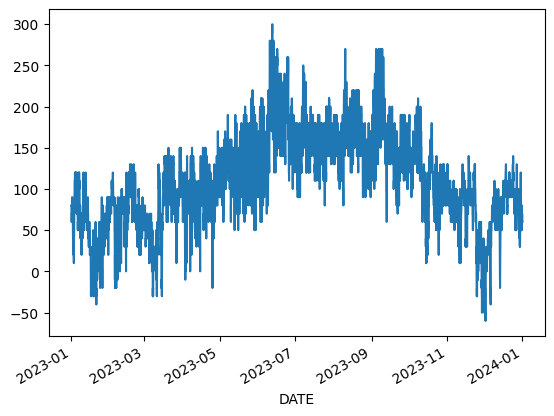

In [11]:
# 5 plotting
df['T_filled'].plot()

### 1.4 Try other station and fill the missing values with different methods and compare the different among them.


1. select station: https://envdes.github.io/obswx/isd_map

2. get 2023 **LEEK THORNCLIFFE** station data

```
    USAF: "033300"
    WBAN: "99999"
    Station Name: "LEEK THORNCLIFFE"
    Country: "UK"
    State: ""
    ICAO: ""
    Latitude: 53.133
    Longitude: -1.983
    Elevation: 299
    Begin: "20040706"
    End: "20240811"
```

3. fill the missing value using `interpolate` with differet methods, and compare the filled value with mean, median the last observation and the next observation.

Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map


<Axes: xlabel='DATE'>

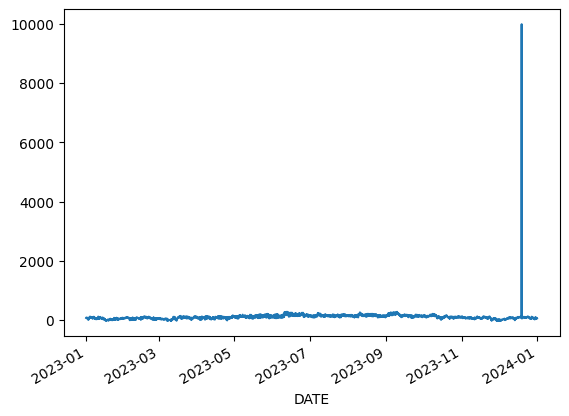

In [ ]:
# try you code in here and the plot is like below



use the index to locate the data

In [ ]:
#example code here:
missing_value_index = lt.query('TMP >= 9999').index
print(lt.loc[missing_value_index]['TMP'])
lt_inter_linear = lt['TMP'].apply(lambda x: x if x < 9999 else np.nan).interpolate(method='linear')
print(lt_inter_linear.loc[missing_value_index])


# please use other method to fill the missing value, and check the result


DATE
2023-12-19 11:00:00    9999.9
2023-12-19 12:00:00    9999.9
Name: TMP, dtype: float64
DATE
2023-12-19 11:00:00    58.433333
2023-12-19 12:00:00    56.766667
Name: TMP, dtype: float64


## 2 train a time serial model using automl
---

### 2.1 download 12 years data

In [12]:
df = pd.DataFrame()
for year in range(2010,2023): # 2012--2022 year
    df_ = met.get_data(year=year, station= "03334099999", isd_source="AWS")
    df = pd.concat([df, df_])

df['TMP'] = df['TMP'].replace(',','.', regex=True).astype(float) # transform the temperature to float
df.index = pd.to_datetime(df['DATE'])
df['T_filled'] = df['TMP'].apply(lambda x: x if x < 9999 else np.nan).interpolate(method='linear') # fill the missing values

Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map
Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map
Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map
Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map
Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map
Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map
Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map
Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map
Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map
Getting data from NOAA ISD
Here to help select station:  https://envdes.github.io/obswx/isd_map
Getting data from NOAA ISD
Here to help 

<Axes: xlabel='DATE'>

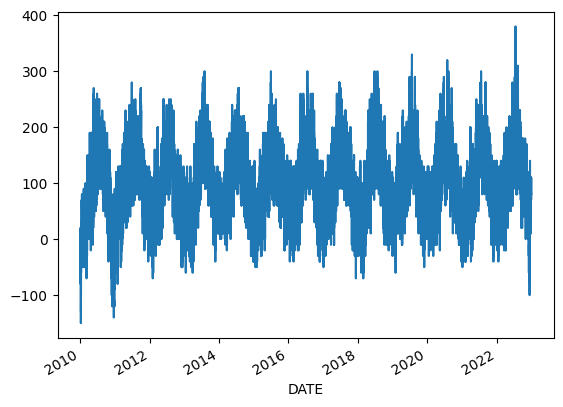

In [13]:
df['T_filled'].plot()

### 2.3 resample the data to monthly data

In [14]:
df_m = df['T_filled'].resample('M').mean().reset_index()
df_m

,DATE,T_filled
0,2010-01-31,10.447978
1,2010-02-28,23.330159
2,2010-03-31,60.106117
3,2010-04-30,87.856189
4,2010-05-31,108.584489
...,...,...
151,2022-08-31,180.983548
152,2022-09-30,140.238889
153,2022-10-31,124.890089
154,2022-11-30,89.082578


### 2.4 Using `flaml` automl package to model the time serial data

In [15]:
# 1 initialize an instance of automl
automl = AutoML()

# 2 use the data excluding last 12 data for training
X_train = df_m.iloc[0:len(df_m)-12]

# 3 train the model
automl.fit(
    dataframe=X_train,  # dataframe with the column of timestamp
    label="T_filled",  # value column name
    period=12,  # time horizon to forecast, e.g., 12 months
    task="ts_forecast",
    time_budget=15,  # time budget in seconds
    log_file_name="ts_forecast.log",
    eval_method="holdout",
    estimator_list=[
        "lgbm",
        "xgboost",
        "extra_tree",
    ],
)

[flaml.automl.logger: 08-15 10:56:39] {1680} INFO - task = ts_forecast
[flaml.automl.logger: 08-15 10:56:39] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 08-15 10:56:39] {1789} INFO - Minimizing error metric: mape


INFO:flaml.automl.task.time_series_task:Couldn't import Prophet, skipping


[flaml.automl.logger: 08-15 10:56:39] {1901} INFO - List of ML learners in AutoML Run: ['lgbm', 'xgboost', 'extra_tree']
[flaml.automl.logger: 08-15 10:56:39] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-15 10:56:40] {2345} INFO - Estimated sufficient time budget=3827s. Estimated necessary time budget=4s.
[flaml.automl.logger: 08-15 10:56:40] {2392} INFO -  at 0.6s,	estimator lgbm's best error=0.4035,	best estimator lgbm's best error=0.4035
[flaml.automl.logger: 08-15 10:56:40] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-15 10:56:40] {2392} INFO -  at 1.0s,	estimator lgbm's best error=0.4035,	best estimator lgbm's best error=0.4035
[flaml.automl.logger: 08-15 10:56:40] {2219} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 08-15 10:56:40] {2392} INFO -  at 1.2s,	estimator lgbm's best error=0.2530,	best estimator lgbm's best error=0.2530
[flaml.automl.logger: 08-15 10:56:40] {2219} INFO - iteration 3, current learne

In [16]:
# 4 use the last 12 data for testing
df_m_test = df_m.iloc[len(df_m)-12:]

In [17]:
# 5 precdtion using the model
prediction = automl.predict(df_m_test)

### 2.5 Ploting

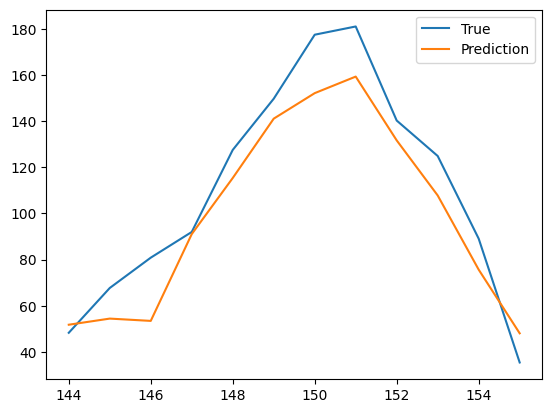

In [18]:
# 6 plot the result
plt.plot(df_m_test['T_filled'], label='True')
plt.plot(prediction, label='Prediction')
plt.legend()

### 2.6 calculate the error metrics

\begin{equation}
    \text{MSE} = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2,
\end{equation}

\begin{equation}
    \text{RMSE} = \sqrt{\text{MSE}} = \sqrt{\frac{1}{n} \sum_{i=1}^n (y_i - \hat{y}_i)^2},
\end{equation}

\begin{equation}
    \text{MAE} = \frac{1}{n} \sum_{i=1}^n |y_i - \hat{y}_i|,
\end{equation}

\begin{equation}
    \text{R2} = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y}_i)^2}{\sum_{i=1}^n (y_i - \bar{y_m})^2},
\end{equation}

where $y_i$ and $y{\hat{}}_i$ are the observations and model predictions, respectively; n is the number of samples; $y_m$ is the mean of the observations.

In [19]:
# example: calculate the MSE
print(f"MSE: {np.mean((df_m_test['T_filled'] - prediction)**2)}")

# calculate the RMSE

# calculate the MAE

# calculate the R2

MSE: 248.20966903100907


## 3 Daily temperature prediction
---

In [21]:
df_D = df['T_filled'].resample('D').mean().reset_index()

In [22]:
automl = AutoML()
X_train = df_D.iloc[0:len(df_D)-30]
X_train['T_filled'] = X_train['T_filled'].fillna(method='ffill')
automl.fit(
    dataframe=X_train,  # dataframe with the column of timestamp
    label="T_filled",  # value column name
    period=1,  # time horizon to forecast
    task="ts_forecast",
    time_budget=60,  # time budget in seconds
    log_file_name="ts_forecast.log",
    eval_method="holdout",
    estimator_list=[
        "lgbm"
    ],
)

[flaml.automl.logger: 08-15 10:58:17] {1680} INFO - task = ts_forecast
[flaml.automl.logger: 08-15 10:58:17] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 08-15 10:58:17] {1789} INFO - Minimizing error metric: mape


INFO:flaml.automl.task.time_series_task:Couldn't import Prophet, skipping


[flaml.automl.logger: 08-15 10:58:17] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 08-15 10:58:17] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-15 10:58:18] {2345} INFO - Estimated sufficient time budget=4766s. Estimated necessary time budget=5s.
[flaml.automl.logger: 08-15 10:58:18] {2392} INFO -  at 0.5s,	estimator lgbm's best error=0.6820,	best estimator lgbm's best error=0.6820
[flaml.automl.logger: 08-15 10:58:18] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-15 10:58:19] {2392} INFO -  at 1.5s,	estimator lgbm's best error=0.6820,	best estimator lgbm's best error=0.6820
[flaml.automl.logger: 08-15 10:58:19] {2219} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 08-15 10:58:19] {2392} INFO -  at 1.6s,	estimator lgbm's best error=0.2841,	best estimator lgbm's best error=0.2841
[flaml.automl.logger: 08-15 10:58:19] {2219} INFO - iteration 3, current learner lgbm
[flaml.automl.logg

In [23]:
test_D = df_D.iloc[len(df_D)-300:]
prediction = automl.predict(test_D)

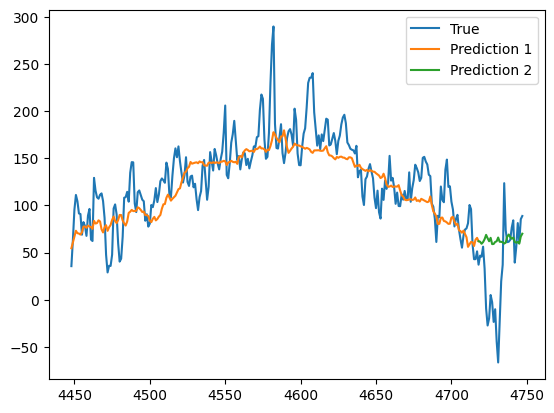

In [24]:
# ploting
plt.plot(test_D['T_filled'], label='True')
plt.plot(prediction.loc[len(df_D)-300:len(df_D)-30], label='Prediction 1')
plt.plot(prediction.loc[len(df_D)-30:], label='Prediction 2')
plt.legend()

the performances of the model is not good.

Q: Why?

1. Model are not well trained.
2. Task are not suitable for the ML modeling
3. Use more variables

Try to modify some paramters of automl

e.g., increasing the `time_budget`. Please try to increase the `time_budget` to 120 second and see what happen.


Q: **Think about the difference in prediction 1 and prediction 2**

## 4 Use more variables to help modeling
---

here we try to use more variables to help modeling

- TMP: temperature
- DEW: dew point
- SLP: sea level pressure

Q: [**what is dew point?**](https://en.wikipedia.org/wiki/Dew_point)

A: The dew point of a given body of air is the temperature to which it must be cooled to become saturated with water vapor. It is very related to the humdity.

In [25]:
# 1 define a function to get more variables
def isd_data_process(var):
  df[var] = df[var].replace(',','.', regex=True).astype(float) # transform the temperature to float
  df[f'{var}_filled'] = df[var].apply(lambda x: x if x < 9999 else np.nan).interpolate(method='linear')

# 2 select TMP, DEW, SLP
for var in ['TMP', 'DEW', 'SLP']:
  isd_data_process(var)

In [26]:
df_md = df[['TMP_filled','DEW_filled','SLP_filled']].resample('D').mean().reset_index().fillna(method='ffill') # fill the na using ffill
automl = AutoML()
X_train = df_md.iloc[0:len(df_md)-30]
automl.fit(
    dataframe=X_train,  # dataframe with the column of timestamp
    label="TMP_filled",  # value column name
    period=1,  # time horizon to forecast
    task="ts_forecast",
    time_budget=60,  # time budget in seconds
    log_file_name="ts_forecast.log",
    eval_method="holdout",
    estimator_list=[
        "lgbm"
    ],
)

[flaml.automl.logger: 08-15 10:59:37] {1680} INFO - task = ts_forecast
[flaml.automl.logger: 08-15 10:59:37] {1691} INFO - Evaluation method: holdout
[flaml.automl.logger: 08-15 10:59:37] {1789} INFO - Minimizing error metric: mape


INFO:flaml.automl.task.time_series_task:Couldn't import Prophet, skipping


[flaml.automl.logger: 08-15 10:59:37] {1901} INFO - List of ML learners in AutoML Run: ['lgbm']
[flaml.automl.logger: 08-15 10:59:37] {2219} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 08-15 10:59:37] {2345} INFO - Estimated sufficient time budget=2883s. Estimated necessary time budget=3s.
[flaml.automl.logger: 08-15 10:59:37] {2392} INFO -  at 0.3s,	estimator lgbm's best error=0.7651,	best estimator lgbm's best error=0.7651
[flaml.automl.logger: 08-15 10:59:37] {2219} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 08-15 10:59:37] {2392} INFO -  at 0.8s,	estimator lgbm's best error=0.7651,	best estimator lgbm's best error=0.7651
[flaml.automl.logger: 08-15 10:59:37] {2219} INFO - iteration 2, current learner lgbm
[flaml.automl.logger: 08-15 10:59:38] {2392} INFO -  at 0.9s,	estimator lgbm's best error=0.4495,	best estimator lgbm's best error=0.4495
[flaml.automl.logger: 08-15 10:59:38] {2219} INFO - iteration 3, current learner lgbm
[flaml.automl.logg

In [27]:
test_md = df_md.iloc[len(df_md)-300:]
prediction = automl.predict(test_md)

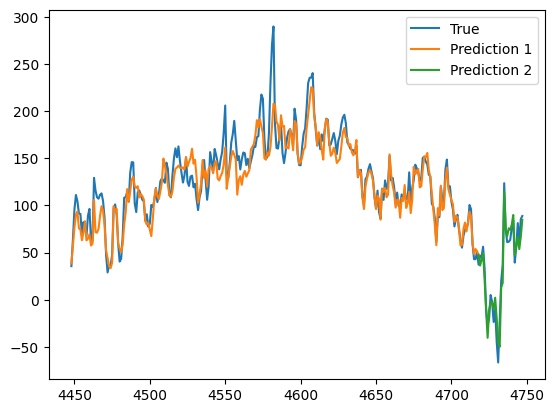

In [29]:
# ploting
plt.plot(test_md['TMP_filled'], label='True')
plt.plot(prediction.loc[len(df_md)-300:len(df_md)-30], label='Prediction 1')
plt.plot(prediction.loc[len(df_md)-30:], label='Prediction 2')
plt.legend()

**Additional Questions:**

Q: How does time horizon to forecast (the parameter period) will affect the model performance?

### Task:
---

1. Find the XIAOSHAN airport station (China, Hangzhou) data from 2010 to 2023, and fill the missing value if have.

2. Train two time-series models 

    1. montly temperature prediction (1-month period)
    
    2. daily temperature prediction (3-day periods)

    3. try to use different `eval_method` methods.

3. Predict the 2024 monthly temperature and compare the result with the true value.

4. Plot and calculate the MAPE.

*optional: try to train model use Kelvin and Celsius